# Seasonify

Convolutional Neural Network to predict the seasonal color of a person.


## 1. Load data


In [1]:
import glob
import numpy as np

# use colorferet

def load_data():
    autumn_path = "./colorferet_smaller/autumn"
    spring_path = "./colorferet_smaller/spring"
    summer_path = "./colorferet_smaller/summer"
    winter_path = "./colorferet_smaller/winter"

    X, y = [], []

    # autumn = 0
    # spring = 1
    # summer = 2
    # winter = 3
    for i, season_path in enumerate([autumn_path, spring_path, summer_path, winter_path]):
        for fname in glob.glob(season_path + "/" + "*[fr][abc]*"): # regex for front images
            X.append(fname)
            y.append(i)
        
    return np.array(X), np.array(y)

X_all, y_all = load_data()

assert len(X_all) == len(y_all)
print("Number of records in dataset: {:d}".format(len(X_all)))

Number of records in dataset: 3890


### 1.1 Visualize samples

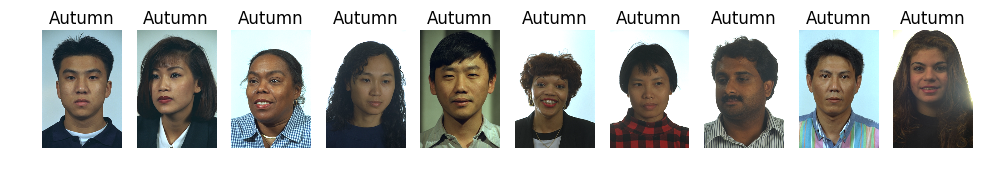

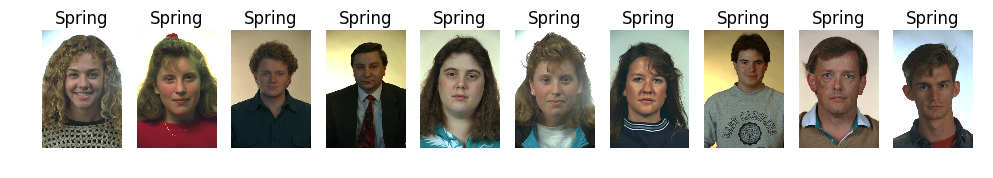

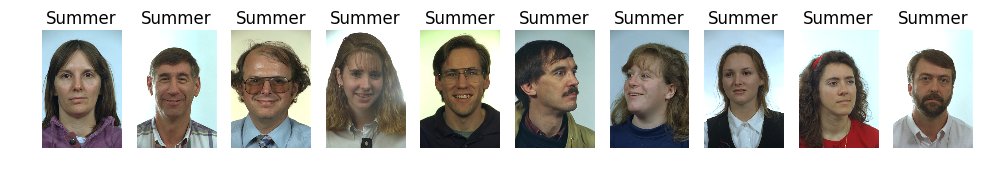

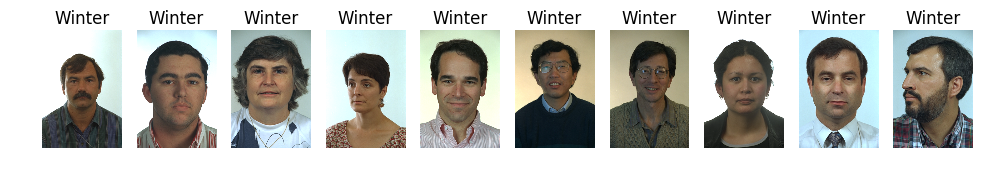

In [20]:
import matplotlib.pyplot as plt
from random import randrange
import cv2
%matplotlib inline

def get_random_images(number, clazz):
    samples = []
    
    while len(samples) < number:
        index = randrange(len(X_all))
        
        y = y_all[index]
        
        if y == clazz:
            samples.append(X_all[index])
            
    return np.array(samples)
        
def plot_images(images, titles):
    assert len(images) == len(titles)
    n = len(images)
    
    f, ax = plt.subplots(1, n, figsize=(12, 12))
    
    for i, a in enumerate(ax):
        a.axis("off")
        a.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        a.set_title(titles[i])

def plot_random_images(number):
    
    for i, clazz in enumerate(["Autumn", "Spring", "Summer", "Winter"]):
        paths = get_random_images(number, i)
        images = []
        titles = []
        for path in paths:
            images.append(cv2.imread(path))
            titles.append(clazz)
        
        plot_images(images, titles)
    
plot_random_images(10)

## 2. Analyze data


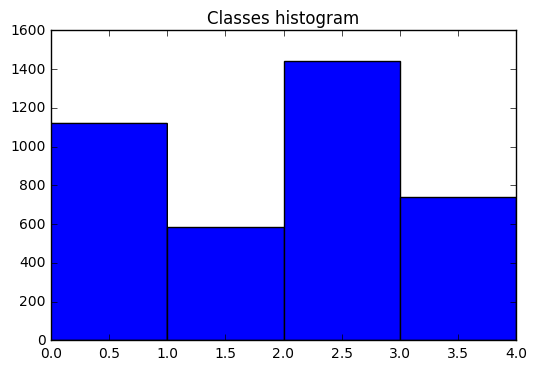

number of elements in class Autumn: 1120
number of elements in class Spring: 587
number of elements in class Summer: 1444
number of elements in class Winter: 739
Shape of samples: (384, 256, 3)


In [3]:
def histogram_of_classes():
    plt.hist(y_all, 4, (0, 4))
    plt.title("Classes histogram")
    plt.show()
    
    print("number of elements in class Autumn: {:d}".format(len(y_all[y_all == 0])))
    print("number of elements in class Spring: {:d}".format(len(y_all[y_all == 1])))
    print("number of elements in class Summer: {:d}".format(len(y_all[y_all == 2])))
    print("number of elements in class Winter: {:d}".format(len(y_all[y_all == 3])))
    
    x_index = randrange(len(X_all))
    x_path = X_all[x_index]
    
    x_sample = cv2.imread(x_path)
    
    print("Shape of samples: {}".format(x_sample.shape))
    
histogram_of_classes()

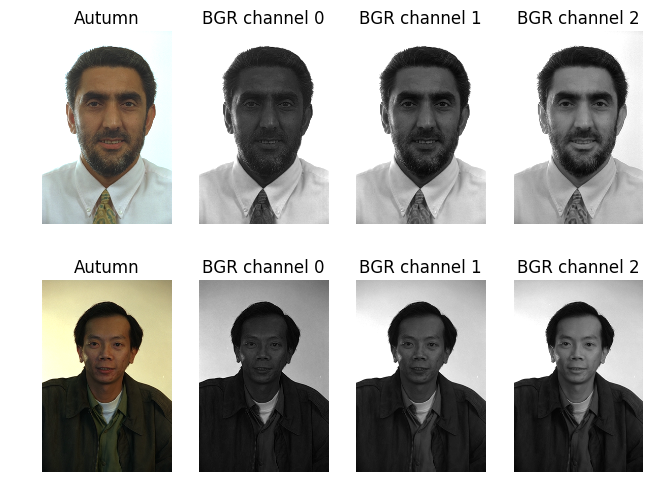

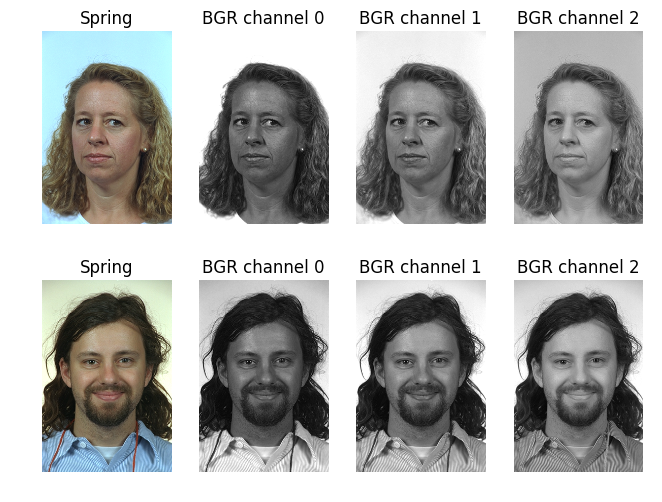

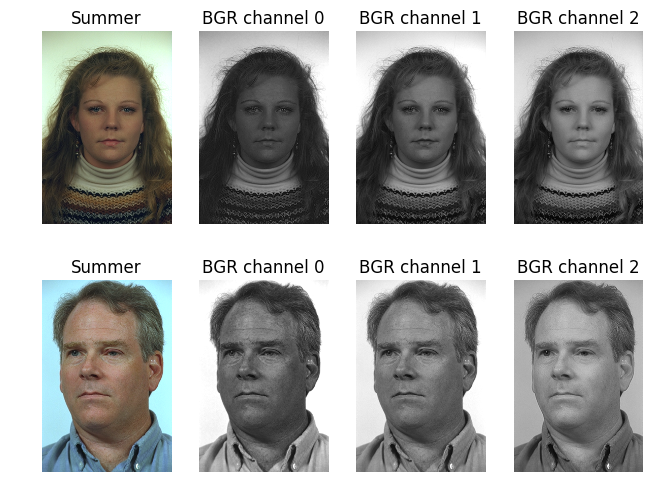

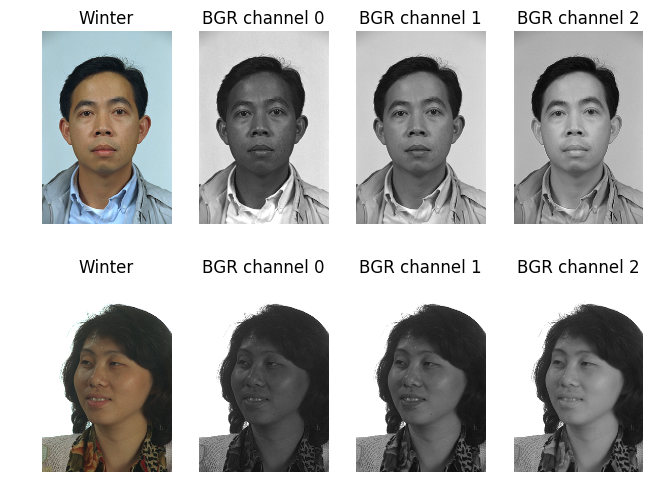

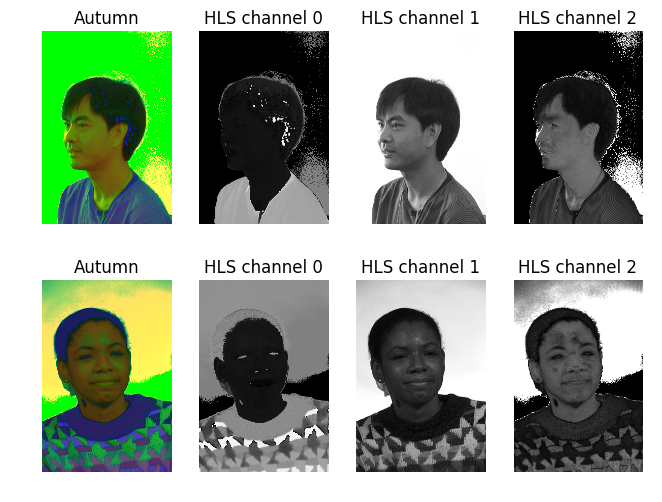

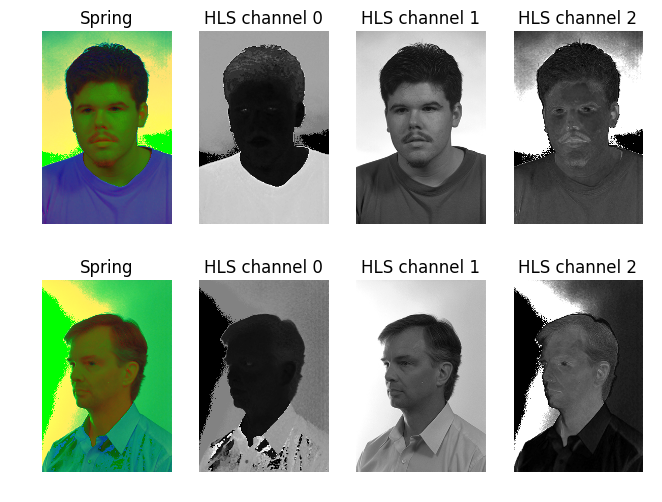

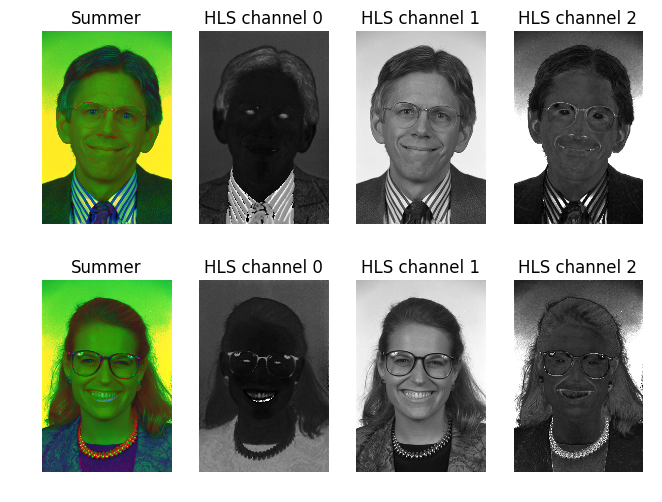

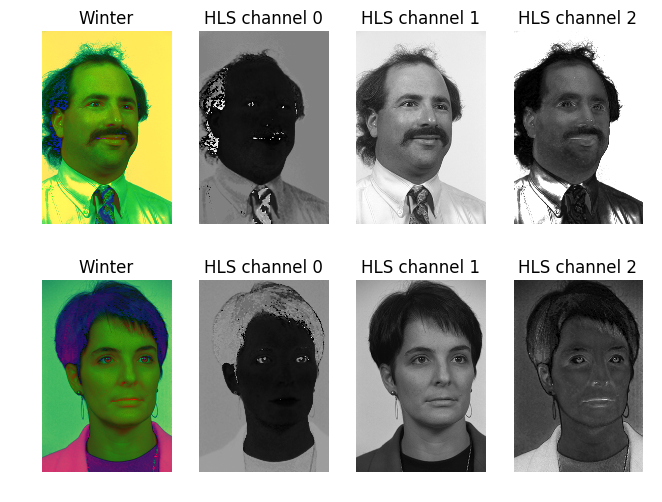

In [21]:
def plot_channels(images, titles, color_space):
    fig, ax = plt.subplots(len(images), 4, figsize=(12, 12))
    fig.tight_layout()
    for i, col in enumerate(ax):
        for j, row in enumerate(col):
            ax[i][j].axis("off")
            if j == 0:
                ax[i][j].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
                ax[i][j].set_title(titles[i])
            elif j == 1:
                ax[i][j].imshow(images[i][:,:,0], cmap="gray")
                ax[i][j].set_title(color_space + " channel 0")
            elif j == 2:
                ax[i][j].imshow(images[i][:,:,1], cmap="gray")
                ax[i][j].set_title(color_space + " channel 1")
            elif j == 3:
                ax[i][j].imshow(images[i][:,:,2], cmap="gray")
                ax[i][j].set_title(color_space + " channel 2")
        
    plt.subplots_adjust(left=0., right=.5, top=.5, bottom=.1)

def visualize_color_space(number, color_space):
    for i, clazz in enumerate(["Autumn", "Spring", "Summer", "Winter"]):
        paths = get_random_images(number, i)
        
        images = []
        titles = []
        for path in paths:
            image = cv2.imread(path)
            titles.append(clazz)
            if color_space == "BGR":
                images.append(image)
            elif color_space == "HLS":
                images.append(cv2.cvtColor(image, cv2.COLOR_BGR2HLS))
        
        plot_channels(images, titles, color_space)
        
visualize_color_space(2, "BGR")
visualize_color_space(2, "HLS")

## 3. Augment Data

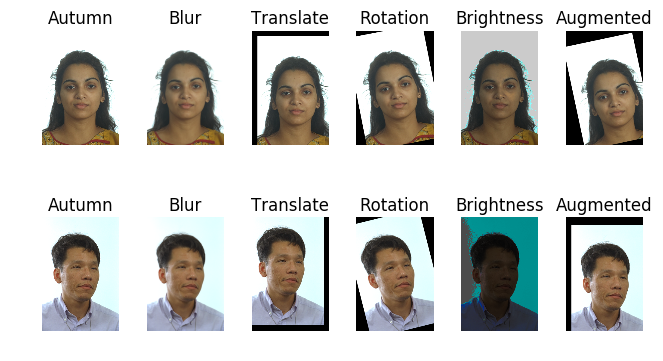

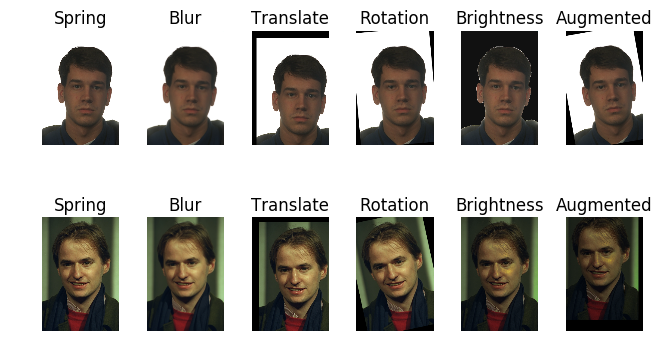

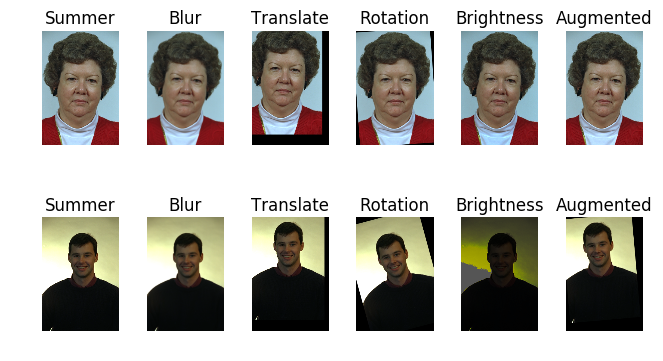

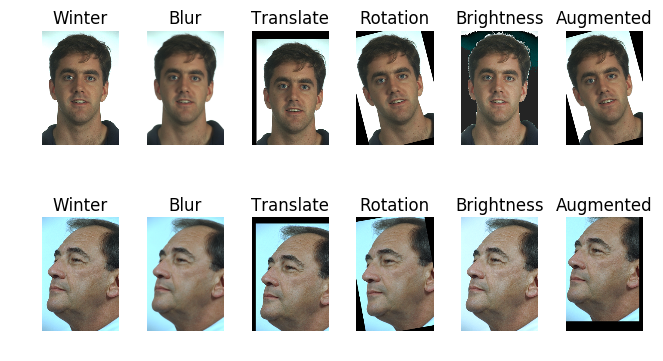

In [30]:
def blur_image(x):
    x_blur = cv2.GaussianBlur(x, (5, 5), 0)
    return x_blur

def translate_image(x):
    h, w, d = x.shape
    
    delta_y = randrange(int(h * 0.05), int(h * 0.1)) # 5 - 10% of height
    delta_x = randrange(int(w * 0.05), int(w * 0.1)) # 5 - 10% of width
    
    factor = 1 if randrange(0, 2) == 0 else -1
    
    delta_y *= factor
    delta_x *= factor
    
    M = np.float32([[1, 0, delta_x], [0, 1, delta_y]])
    x_translated = cv2.warpAffine(x, M, (w, h))
    
    return x_translated

def rotate_image(x):
    h, w, d = x.shape

    delta = randrange(1, 16) # between 0 - 15 degrees

    M = cv2.getRotationMatrix2D((w/2,h/2), delta, 1)
    x_rotated = cv2.warpAffine(x, M, (w, h))
    
    return x_rotated

def bright_image(x_bgr):
    hls = cv2.cvtColor(x_bgr, cv2.COLOR_BGR2HLS)
    hls[:,:,1] = hls[:,:,1] * (0.25 + np.random.uniform()) 
    return cv2.cvtColor(hls, cv2.COLOR_HLS2BGR)

def augment_image(x, random_limit):
    
    augmented = np.copy(x)
    limit = random_limit

    factor = randrange(0, limit)
    if factor == 0:
        augmented = blur_image(augmented)
        
    factor = randrange(0, limit)
    if factor == 0:
        augmented = translate_image(augmented)
        
    factor = randrange(0, limit)
    if factor == 0:
        augmented = rotate_image(augmented)
        
    factor = randrange(0, limit)
    if factor == 0:
        augmented = bright_image(augmented)
        
    return augmented
    
def plot_augmentations(images, titles):
    fig, ax = plt.subplots(len(images), 6, figsize=(12, 12))
    fig.tight_layout()
    for i, col in enumerate(ax):
        for j, row in enumerate(col):
            ax[i][j].axis("off")
            if j == 0:
                ax[i][j].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
                ax[i][j].set_title(titles[i])
            elif j == 1:
                ax[i][j].imshow(cv2.cvtColor(blur_image(images[i]), cv2.COLOR_BGR2RGB))
                ax[i][j].set_title("Blur")
            elif j == 2:
                ax[i][j].imshow(cv2.cvtColor(translate_image(images[i]), cv2.COLOR_BGR2RGB))
                ax[i][j].set_title("Translate")
            elif j == 3:
                ax[i][j].imshow(cv2.cvtColor(rotate_image(images[i]), cv2.COLOR_BGR2RGB))
                ax[i][j].set_title("Rotation")
            elif j == 4:
                ax[i][j].imshow(cv2.cvtColor(bright_image(images[i]), cv2.COLOR_BGR2RGB))
                ax[i][j].set_title("Brightness")
            elif j == 5:
                ax[i][j].imshow(cv2.cvtColor(augment_image(images[i], 2), cv2.COLOR_BGR2RGB))
                ax[i][j].set_title("Augmented")
                
    plt.subplots_adjust(left=0., right=.5, top=.5, bottom=.2)


def visualize_augmentations(number):
    
    for i, clazz in enumerate(["Autumn", "Spring", "Summer", "Winter"]):
        paths = get_random_images(number, i)
        
        images = []
        titles = []
        for path in paths:
            image = cv2.imread(path)
            images.append(image)
            titles.append(clazz)
        
        plot_augmentations(images, titles)

visualize_augmentations(2)


## 4. Define Model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, ELU, Activation, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam

final_width = 100
final_height = 150
final_depth = 3
drop_out = .2
    
def get_model(learning):
        
    image_shape = (final_height, final_width, final_depth)

    print(image_shape)
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=image_shape, output_shape=image_shape))
    
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    #model.add(Dropout(drop_out))
    
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    #model.add(Dropout(drop_out))
    
    model.add(Convolution2D(64, 3, 3, border_mode="valid"))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(64, 3, 3, border_mode="valid"))
    #model.add(Dropout(drop_out))
    
    model.add(Flatten())
    model.add(Activation('relu'))

    model.add(Dense(100))
    model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))
    #model.add(Dropout(.2))

    model.add(Dense(10))
    model.add(Activation('relu'))

    model.add(Dense(1))

    optimizer = Adam(lr=learning)
    model.compile(optimizer=optimizer, loss="mse")

    return model


Using TensorFlow backend.


## 5. Train model


In [34]:
def resize(image, width, height):
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC)

def generator(Xpath, y, batch_size):

    total_input = len(Xpath)
    
    while True:
        features, targets = [], []
        i = 0
        while len(features) < batch_size:
            index = randrange(0, total_input)
            path = Xpath[index]
            
            angle = y[index]
            image = cv2.imread(path)
            image = augment_image(image, 2)
            image = resize(image, final_width, final_height)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
           
            features.append(image)
            targets.append(angle)
            
        yield (np.array(features), np.array(targets))

def getFeaturesTargets(Xpath, y):
    feats = []
    targets = []
    for path, angle in zip(Xpath, y):
        image = cv2.imread(path)
        image = resize(image, final_width, final_height)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        feats.append(image)
        targets.append(angle)

    return np.array(feats), np.array(targets)

def plot_metrics(history):
    keys = history.history.keys()

    for k in keys:
        plt.clf()
        plt.plot(history.history[k])
        plt.title("model " + k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.show()
        
import json

def train_model(X_train, y_train, X_val, y_val):
    learning_rate = 0.001
    training_size = 3200
    batch_size = 160
    learning_rate = 0.001
    epochs = 30

    model = get_model(learning_rate)

    history =  model.fit_generator(
            generator(X_train, y_train, batch_size),
            samples_per_epoch = training_size,
            validation_data = getFeaturesTargets(X_val, y_val),
            nb_epoch = epochs
        )
 
    model.save_weights("model.h5")
    with open("model.json", "w+") as outfile:
        json.dump(model.to_json(), outfile)

    plot_metrics(history)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=50)
train_model(X_train, y_train, X_test, y_test)

(150, 100, 3)
Epoch 1/30
2240/3200 [====================>.........] - ETA: 15s - loss: 1.7527

KeyboardInterrupt: 

## 6. Predict

In [35]:
def preprocess_image(x):
    x = resize(x, final_width, final_height)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2HLS)
    
    return x

def make_prediction(clf, image):
    pred = clf.predict(box_feats.reshape((1, -1)), batch_size=1)
    pred = int(np.abs(pred[0][0]))
    
    return pred

def plot_images(images, titles):
    assert len(images) == len(titles)
    n = len(images)
    
    f, ax = plt.subplots(1, n, figsize=(12, 12))
    
    for i, a in enumerate(ax):
        a.axis("off")
        a.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        a.set_title(titles[i])

def plot_random_predictions(number):
    with open("model.json", 'r') as jfile:
        model = model_from_json(json.loads(jfile.read()))\

    model.compile("adam", "mse")
    model.load_weights("model.h5")
    
    classes = ["Autumn", "Spring", "Summer", "Winter"]
    for i, clazz in enumerate(classes):
        paths = get_random_images(number, i)
        images = []
        titles = []
        for path in paths:
            image = cv2.imread(path)
            image_pre = preprocess_image(image)
            prediction = make_prediction(model, image_pre)
            
            title = "Real: {}, Predicted{}".format(clazz, classes[i])
            
            images.append(image)
            titles.append(clazz)
        
        plot_images(images, titles)

plot_random_predictions(10)  